In [ ]:
%env "WANDB_NOTEBOOK_NAME" "11_homo_sine_loss_strat_pruning.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.5

env: "WANDB_NOTEBOOK_NAME"="11_hetero_sine_loss_strat_pruning.ipynb"
env: WANDB_SILENT=True
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.5


In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot
import os
import sys
import logging
from tqdm.notebook import trange
import wandb

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
input_size = 1
hidden_sizes = [50, 50] 
output_size = 1
initial_activation_list = [sin]
activation_list = [sin]
bias = False
num_epochs = 5000
remove_node_every = 50
seed = 42
key = jax.random.PRNGKey(seed)
threshold = 1e-3
n_samples = 2000
learning_rate = 0.01
train_period = 1000

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                bias=bias,
                seed=seed)

2024-06-03 08:49:08.144218: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'remove_node_every': remove_node_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
jax.config.update('jax_platform_name', 'cpu')
Description = f"Homo_sine_loss_strat_pruning_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{train_period}_{remove_node_every}_{threshold}_{seed}"
fig_folder = f"../figures/{Description}"
out_folder = f"../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Homo_sine_loss_strat_pruning_50_50_5000_1000_50_0.001_42
jax backend: cpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
mlp = CustomMLP(config)

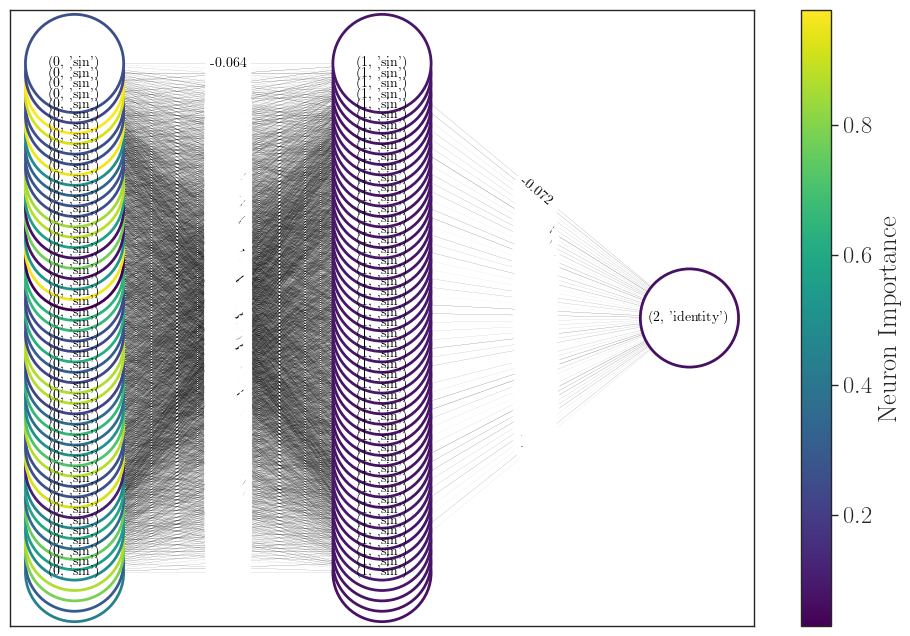

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.linspace(0, 2*jnp.pi, n_samples).reshape(-1, 1)
y = jnp.sin(x)

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

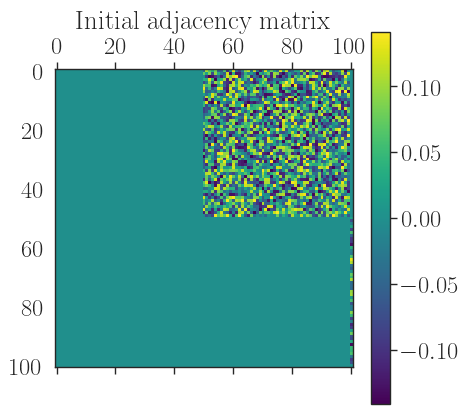

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

In [ ]:
Loss_history = []
Node_history = []
graph_history = []
Update_history = []


### Initial training

In [ ]:
for epoch in range(train_period):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)



Epoch 0, Loss: 0.5550111293483019
Epoch 000, Loss: 0.5550111293483019, Neurons: 101
Epoch 1, Loss: 0.1782309423886806
Epoch 001, Loss: 0.1782309423886806, Neurons: 101
Epoch 2, Loss: 0.18723100118491545
Epoch 002, Loss: 0.18723100118491545, Neurons: 101
Epoch 3, Loss: 0.22185670235033447
Epoch 003, Loss: 0.22185670235033447, Neurons: 101
Epoch 4, Loss: 0.1375295277496092
Epoch 004, Loss: 0.1375295277496092, Neurons: 101
Epoch 5, Loss: 0.05587965021180896
Epoch 005, Loss: 0.05587965021180896, Neurons: 101
Epoch 6, Loss: 0.0373897894247151
Epoch 006, Loss: 0.0373897894247151, Neurons: 101
Epoch 7, Loss: 0.05901892672414051
Epoch 007, Loss: 0.05901892672414051, Neurons: 101
Epoch 8, Loss: 0.07495787291251613
Epoch 008, Loss: 0.07495787291251613, Neurons: 101
Epoch 9, Loss: 0.06711944252328104
Epoch 009, Loss: 0.06711944252328104, Neurons: 101
Epoch 10, Loss: 0.04248836231133474
Epoch 010, Loss: 0.04248836231133474, Neurons: 101
Epoch 11, Loss: 0.017086620825612166
Epoch 011, Loss: 0.01708

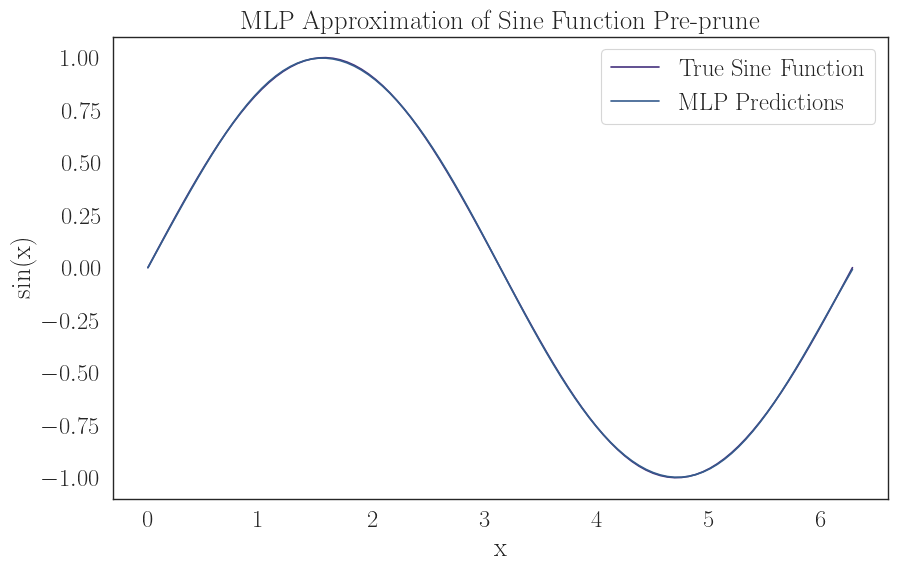

In [ ]:
x_test = jnp.linspace(0, 2*jnp.pi, 100).reshape(-1, 1)
y_test = jnp.sin(x_test)
y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label="True Sine Function")
plt.plot(x_test, y_pred, label="MLP Predictions")
plt.legend()
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("MLP Approximation of Sine Function Pre-prune")
plt.savefig(f"{fig_folder}/sine_approximation.png")
wandb.log({"pre-prune sine approximation": wandb.Image(plt, caption="sine approximation")})

### Pruning

In [ ]:
put_back_counter = 0

In [ ]:
for epoch in range(train_period, num_epochs+ train_period):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Loss: {loss}")
    key = jax.random.PRNGKey(epoch)
    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)

    if put_back_counter > 10:
        logging.info("Early stopping, loss did not improve after replacing neuron 10 times")
        wandb.log({"early stopping": epoch})
        break
    
    if loss > threshold and n_neurons <= 10:
        logging.info("Early stopping, loss above threshold")
        wandb.log({"early stopping": epoch})
        break

    # Dynamically add or remove neurons
    if (epoch + 1) % remove_node_every == 0:
        # remove criteria
        # if no neuron was removed, remove the random neuron
        # if neuron was removed, check if loss is within threshold, else put it back
        # if loss is higher than threshold, and neuron added 10 times, stop training

        if loss > threshold:
            logging.info("Early stopping, loss above threshold")
            wandb.log({"early stopping": epoch})
            break




        if len(Update_history) == 0 or (loss - Update_history[-1][2]) < threshold:
            # remove
            layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
            layers = len(mlp.get_shape()) - 1
            layer = jax.random.randint(sub_key, (1,), 0, layers)[0]
            neurons = len(mlp.layers[layer]) -1
            neuron_idx = jax.random.randint(neuron_key, (1,), 0, neurons)[0]
            neuron_act = mlp.layers[layer][neuron_idx].activation
            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer))

            logging.info(f"Removed {neuron_act.__name__} neuron in hidden layer {layer+1} at index {neuron_idx}")
            wandb.log({"removed neuron": neuron_idx})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        # remove criteria
        elif (loss - Update_history[-1][2]) > threshold:
            # put last neuron back
            put_back_counter += 1
            layer = Update_history[-1][4]
            activation = neuron_act
            mlp.add_neuron(layer_index=layer, activation=activation, bias = bias, key = add_key)

            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer))
            logging.info(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            wandb.log({"added neuron": activation.__name__})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        

Epoch 1000, Loss: 7.0919789400024025e-06
Epoch 1000, Loss: 7.0919789400024025e-06, Neurons: 101
Epoch 1001, Loss: 7.07576844339323e-06
Epoch 1001, Loss: 7.07576844339323e-06, Neurons: 101
Epoch 1002, Loss: 7.059662012619213e-06
Epoch 1002, Loss: 7.059662012619213e-06, Neurons: 101
Epoch 1003, Loss: 7.043657923189839e-06
Epoch 1003, Loss: 7.043657923189839e-06, Neurons: 101
Epoch 1004, Loss: 7.027754993248816e-06
Epoch 1004, Loss: 7.027754993248816e-06, Neurons: 101
Epoch 1005, Loss: 7.011951707284074e-06
Epoch 1005, Loss: 7.011951707284074e-06, Neurons: 101
Epoch 1006, Loss: 6.9962467690656524e-06
Epoch 1006, Loss: 6.9962467690656524e-06, Neurons: 101
Epoch 1007, Loss: 6.980638846661624e-06
Epoch 1007, Loss: 6.980638846661624e-06, Neurons: 101
Epoch 1008, Loss: 6.9651265767540045e-06
Epoch 1008, Loss: 6.9651265767540045e-06, Neurons: 101
Epoch 1009, Loss: 6.949708745644444e-06
Epoch 1009, Loss: 6.949708745644444e-06, Neurons: 101
Epoch 1010, Loss: 6.934383963650818e-06
Epoch 1010, Loss

Epoch 1014, Loss: 6.873991249833282e-06
Epoch 1014, Loss: 6.873991249833282e-06, Neurons: 101
Epoch 1015, Loss: 6.859113619989381e-06
Epoch 1015, Loss: 6.859113619989381e-06, Neurons: 101
Epoch 1016, Loss: 6.844321781939153e-06
Epoch 1016, Loss: 6.844321781939153e-06, Neurons: 101
Epoch 1017, Loss: 6.829614702394871e-06
Epoch 1017, Loss: 6.829614702394871e-06, Neurons: 101
Epoch 1018, Loss: 6.8149911455473e-06
Epoch 1018, Loss: 6.8149911455473e-06, Neurons: 101
Epoch 1019, Loss: 6.8004500913140195e-06
Epoch 1019, Loss: 6.8004500913140195e-06, Neurons: 101
Epoch 1020, Loss: 6.7859903684876815e-06
Epoch 1020, Loss: 6.7859903684876815e-06, Neurons: 101
Epoch 1021, Loss: 6.771610962171996e-06
Epoch 1021, Loss: 6.771610962171996e-06, Neurons: 101
Epoch 1022, Loss: 6.757310754784935e-06
Epoch 1022, Loss: 6.757310754784935e-06, Neurons: 101
Epoch 1023, Loss: 6.743088741848615e-06
Epoch 1023, Loss: 6.743088741848615e-06, Neurons: 101
Epoch 1024, Loss: 6.728943862482051e-06
Epoch 1024, Loss: 6.

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", Node_history)
np.savetxt(f"{out_folder}/loss.txt", Loss_history)

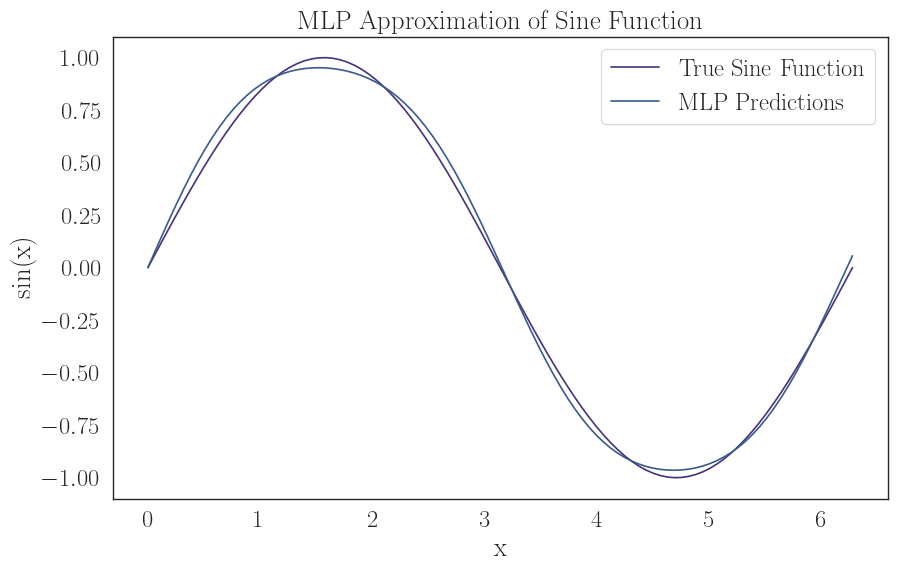

In [ ]:
x_test = jnp.linspace(0, 2*jnp.pi, 100).reshape(-1, 1)
y_test = jnp.sin(x_test)
y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label="True Sine Function")
plt.plot(x_test, y_pred, label="MLP Predictions")
plt.legend()
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("MLP Approximation of Sine Function")
plt.savefig(f"{fig_folder}/sine_approximation.png")
wandb.log({"sine approximation": wandb.Image(plt, caption="sine approximation")})

In [ ]:
Update_history

[(1049,
  101,
  Array(6.3976782e-06, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1099,
  100,
  Array(0.00014665, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1149,
  99,
  Array(0.00013572, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1199,
  98,
  Array(0.00013271, dtype=float64),
  'removed',
  Array(1, dtype=int64)),
 (1249,
  97,
  Array(7.94731543e-05, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1299,
  96,
  Array(0.00010791, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1349,
  95,
  Array(8.35107296e-05, dtype=float64),
  'removed',
  Array(0, dtype=int64)),
 (1399,
  94,
  Array(0.00018512, dtype=float64),
  'removed',
  Array(1, dtype=int64)),
 (1449,
  93,
  Array(0.00017373, dtype=float64),
  'removed',
  Array(1, dtype=int64)),
 (1499,
  92,
  Array(4.09317103e-05, dtype=float64),
  'removed',
  Array(1, dtype=int64)),
 (1549,
  91,
  Array(0.00012192, dtype=float64),
  'removed',
  Array(1, dtype=int64)),
 (15

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

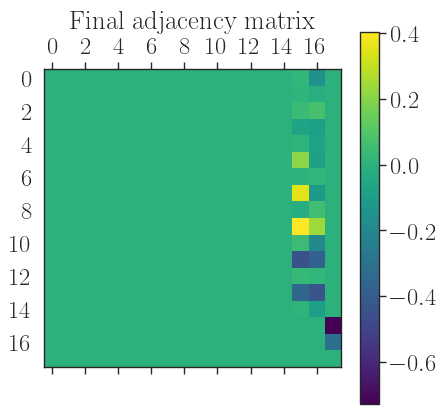

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

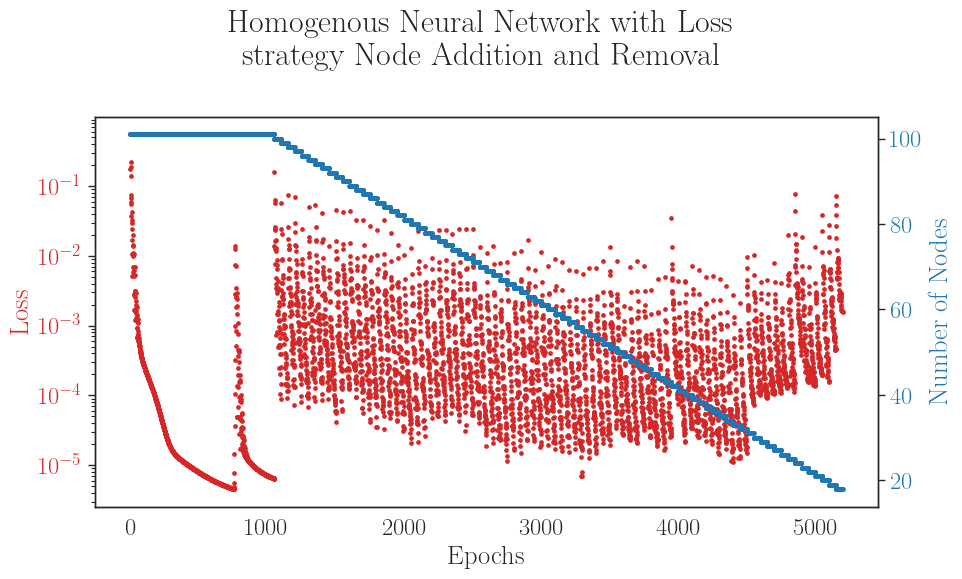

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Loss\n strategy Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

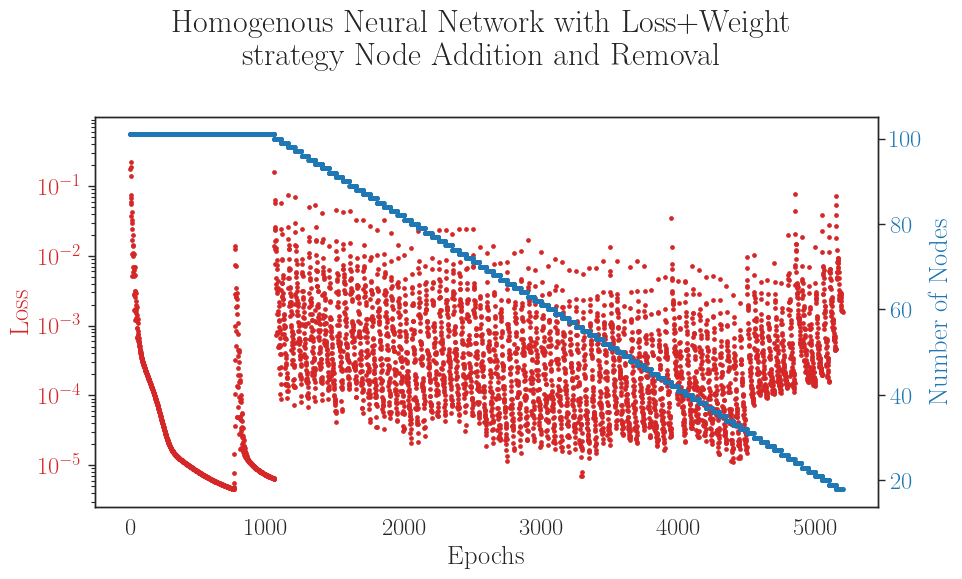

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Loss\n strategy Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

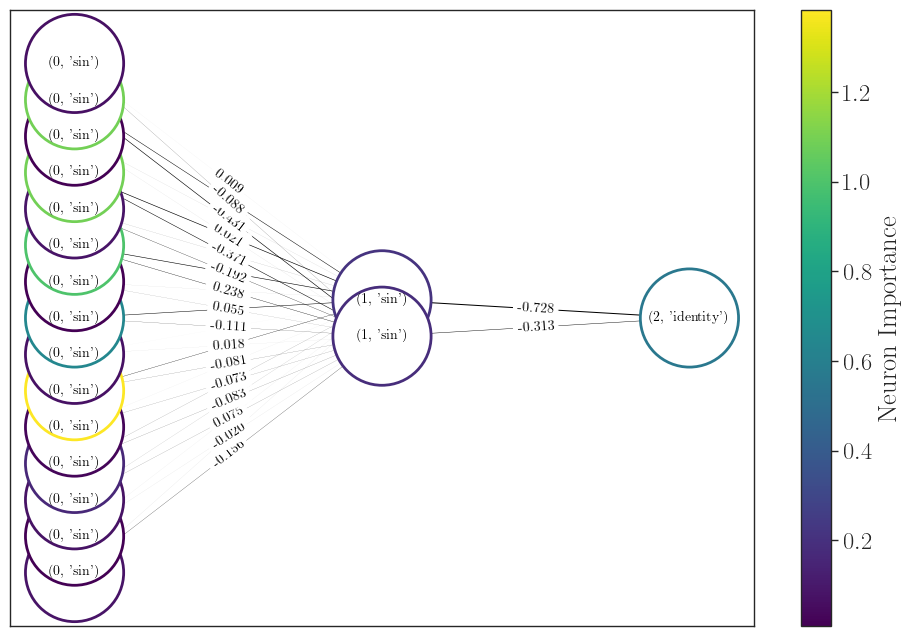

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()